#1. Downloading and Annotating Data

In [12]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing
import scipy.signal
from scipy import signal
import torch
import glob

In [13]:
! rm -r data

Downloading the data

In [14]:
!mkdir data
!cd data && wget https://archive.org/download/dog-barks-raw/Dog%20Bark%20Data.zip
!cd data && unzip -q "Dog Bark Data.zip"
# !ls data/"Dog Bark Data"/Dog

--2025-03-26 02:41:21--  https://archive.org/download/dog-barks-raw/Dog%20Bark%20Data.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dn790000.ca.archive.org/0/items/dog-barks-raw/Dog%20Bark%20Data.zip [following]
--2025-03-26 02:41:21--  https://dn790000.ca.archive.org/0/items/dog-barks-raw/Dog%20Bark%20Data.zip
Resolving dn790000.ca.archive.org (dn790000.ca.archive.org)... 184.105.203.167
Connecting to dn790000.ca.archive.org (dn790000.ca.archive.org)|184.105.203.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1943878068 (1.8G) [application/zip]
Saving to: ‘Dog Bark Data.zip’

Dog Bark Data.zip   100%[===================>]   1.81G  79.6MB/s    in 75s     

2025-03-26 02:42:37 (24.6 MB/s) - ‘Dog Bark Data.zip’ saved [1943878068/1943878068]



Annotating the data

In [15]:
paths = glob.glob('data/**/**/**/**/*.aif') + glob.glob('data/**/**/**/**/*.wav')

In [16]:
# This is the number of audiofiles
len(paths)

720

In [17]:
!mkdir data/audio

In [18]:
# Copied straight from the Earth Species github
import re
import shutil

filename = []
name = []
context = []

for path in paths:
    try:
        n, session, c, session_sequence, *_ = re.findall('(\w+)', path.split('/')[-1])
        if c not in ['A', 'C', 'P']:
            n, c, *_ = re.findall('(\w+)', path.split('/')[-1])
            if c not in ['A', 'C', 'P']:
                n, _, c = re.findall('(\w+)', path.split('/')[-1])
                c = c[0]
                if c not in ['A', 'C', 'P']: continue
    except:
        continue
    shutil.copy(path, 'data/audio')
    filename.append(path.split('/')[-1])
    name.append(n)
    context.append(c)

In [19]:
# Copied from Earth Species github
# This code parses the file names to extract the labels
fix_names = {
    'Freid3': 'Freid',
    'Freid4': 'Freid',
    'Fried': 'Freid',
    'Keri3': 'Keri',
    'Kerik': 'Keri',
    'Zzoe': 'Zoe',
    'luke': 'Luke',
    'Louis': 'Louie'

}

name = [n if n not in fix_names.keys() else fix_names[n] for n in name]

age_map = {
    'Farley': 3,
    'Freid': 5,
    'Keri': 4,
    'Louie': 2,
    'Luke': 5,
    'Mac': 5,
    'Roodie': 12,
    'Rudy': 11,
    'Siggy': 11,
    'Zoe': 7
}

weight_map = {
    'Farley': 25,
    'Freid': 6,
    'Keri': 34,
    'Louie': 19,
    'Luke': 25,
    'Mac': 34,
    'Roodie': 18,
    'Rudy': 32,
    'Siggy': 36,
    'Zoe': 16
}

sex_map = {
    'Farley': 'male',
    'Freid': 'male',
    'Keri': 'female',
    'Louie': 'male',
    'Luke': 'male',
    'Mac': 'male',
    'Roodie': 'male',
    'Rudy': 'male',
    'Siggy': 'male',
    'Zoe': 'female'
}

breed_map = {
    'Farley': 'Australian shepherd',
    'Freid': 'Dachsund',
    'Keri': 'Labrador mix',
    'Louie': 'Springer spaniel',
    'Luke': 'Australian shepherd',
    'Mac': 'German shorthair pointer',
    'Roodie': 'Australian cattle dog',
    'Rudy': 'German shorthair pointer',
    'Siggy': 'German shorthair pointer',
    'Zoe': 'Australian cattle dog'
}

age, weight, sex, breed = zip(*[(age_map[n], weight_map[n], sex_map[n], breed_map[n]) for n in name])

In [20]:
# Copied from Earth Species
# Creates a dataframe with all the different labels corresponding to each bark file
import pandas as pd

anno = pd.DataFrame(data={
    'filename': filename,
    'name': name,
    'context': context,
    'age': age,
    'weight': weight,
    'sex': sex,
    'breed': breed
})
context_map = {
    'A': 'aggression',
    'C': 'contact',
    'P': 'play'
}

anno.context = anno.context.apply(lambda c: context_map[c])

In [21]:
anno.head()

,filename,name,context,age,weight,sex,breed
0,Siggy-4-P-4a.aif,Siggy,play,11,36,male,German shorthair pointer
1,Siggy-4-C-4d.aif,Siggy,contact,11,36,male,German shorthair pointer
2,Siggy-4-C-4c.aif,Siggy,contact,11,36,male,German shorthair pointer
3,Siggy-4-C-4f.aif,Siggy,contact,11,36,male,German shorthair pointer
4,Siggy-4-P-4c.aif,Siggy,play,11,36,male,German shorthair pointer


In [22]:
# Drop empty file
anno = anno[anno.filename != 'Siggy-4-A-4.aif']
# Create a csv file of the annotation
anno.to_csv('data/annotations.csv', index=False)

# 2. Generating Spectrograms

In [23]:
!cd ..
anno = pd.read_csv('data/annotations.csv')

audio = []

for _, row in anno.iterrows():
    recording, sr = librosa.load(f'data/audio/{row.filename}', sr=None)
    audio.append(recording)

anno['audio'] = audio

In [24]:
anno.head()

,filename,name,context,age,weight,sex,breed,audio
0,Siggy-4-P-4a.aif,Siggy,play,11,36,male,German shorthair pointer,"[0.07185364, 0.087509155, 0.09187317, 0.099029..."
1,Siggy-4-C-4d.aif,Siggy,contact,11,36,male,German shorthair pointer,"[-0.00015258789, 0.00064086914, 0.0004272461, ..."
2,Siggy-4-C-4c.aif,Siggy,contact,11,36,male,German shorthair pointer,"[0.0022583008, 0.0006866455, 0.0005187988, 0.0..."
3,Siggy-4-C-4f.aif,Siggy,contact,11,36,male,German shorthair pointer,"[0.0019836426, 0.0011901855, 0.0004272461, 6.1..."
4,Siggy-4-P-4c.aif,Siggy,play,11,36,male,German shorthair pointer,"[0.00074768066, -0.00012207031, -0.00065612793..."


In [25]:
sample_rate = 44100
def audio_to_spec(audio, sample_rate):
  # Compute spectrogram using SciPy
  freqs, times, Sx = signal.spectrogram(audio, fs=sample_rate)

  # Limit the frequency range to about 10kHz to limit computation
  freqs, Sx = freqs[:59], Sx[:59]

  # Convert to decibels (log-scale)
  epsilon = 1e-10  # Small constant to avoid log(0)
  Sx = 10 * np.log10(Sx + epsilon)

  return times, freqs, Sx

In [26]:
def plot_spectrogram(audio, sample_rate, title="Spectrogram"):
    times, freqs, Sx = audio_to_spec(audio, sample_rate)

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(times, freqs / 1000, Sx, cmap='viridis')  # Convert to kHz
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [kHz]')
    plt.title(title)
    plt.colorbar(label='Power (dB)')
    plt.show()



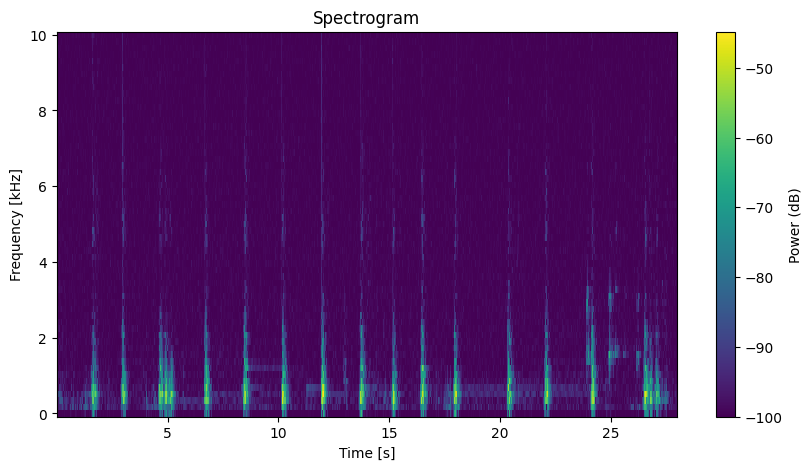

In [27]:
# example
example_audio = anno["audio"][10]
plot_spectrogram(example_audio, sample_rate)

# 3. Segmenting Barks Using Clustering



Function to visualize the clustering

In [28]:
# Function to visualize bark segments
def visualize_bark_segments(audio_path, bark_groups, sample_rate, y):
    # Time axis
    time_axis = np.linspace(0, len(y) / sample_rate, num=len(y))

    plt.figure(figsize=(12, 5))
    librosa.display.waveshow(y, sr=sample_rate, alpha=0.5, color='gray', label="Waveform")

    # Highlight merged bark segments
    for start, end in bark_groups:
        plt.axvspan(start * (1), end * (1), color='red', alpha=0.3)  # Convert segment index to seconds

    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title(f"Bark Segmentation Visualization for {audio_path}")
    plt.legend(["Legend", "Waveform", "Bark (Red)"])
    plt.show()

Detecting barks using k-means clustering.

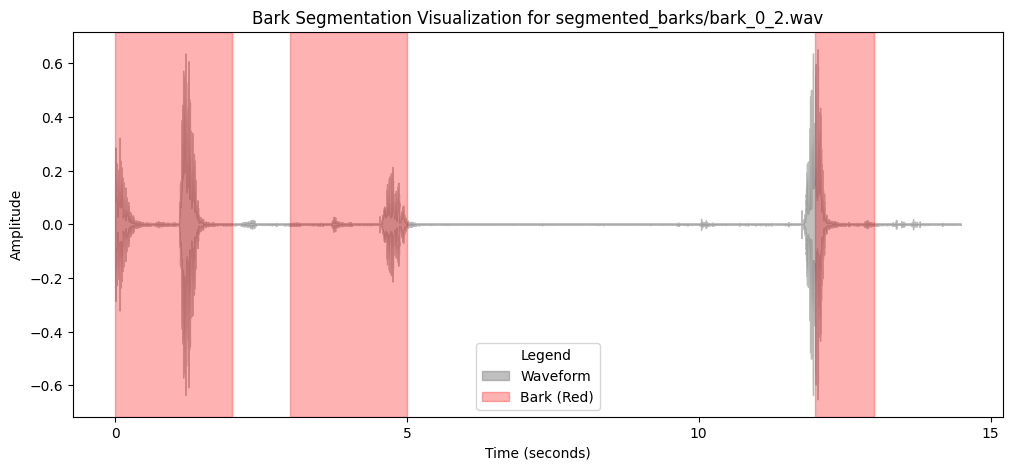

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import soundfile as sf
import os

frame_length = 2048
hop_length = 512

# Since we want segments all of 1 second, segment length equals sampling rate
segment_length_s = 0.5
segment_length = int(sample_rate*segment_length_s)

# Make folder to store extracted barks
output_folder = "segmented_barks"
os.makedirs(output_folder, exist_ok=True)

all_labels = []
plotted = False
for file_idx, a in enumerate(audio):
  # Split audio into 1 second chunks
  segments = librosa.util.frame(a, frame_length=segment_length, hop_length=segment_length).T

  # Extract relevant features from each segment, in this case RMS
  features = []
  # store rms values for label correction
  rms_values = []
  for segment in segments:
    zcr = np.mean(librosa.feature.zero_crossing_rate(segment))  # Mean ZCR
    rms = np.mean(librosa.feature.rms(y=segment))  # Mean Energy
    centroid = np.mean(librosa.feature.spectral_centroid(y=segment, sr=sample_rate))  # Spectral Centroid
    mfcc = np.mean(librosa.feature.mfcc(y=segment, sr=sample_rate, n_mfcc=13), axis=1)  # MFCCs
    feature_vector = np.hstack([zcr, rms, centroid, mfcc])
    features.append(feature_vector)
    rms_values.append(rms)
  features = np.array(features)
  rms_values = np.array(rms_values)

  # Normalize
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(features)

  # K-Means
  kmeans = KMeans(n_clusters=2, random_state=42)
  labels = kmeans.fit_predict(features_scaled)

  # Label correction, 1 represents bark
  # This is done by assuming that a higher RMS => bark
  rms_per_cluster = [np.mean(rms_values[labels == cluster]) for cluster in np.unique(labels)]
  bark_cluster = np.argmax(rms_per_cluster)  # Identify high-energy cluster
  labels = np.array([1 if label == bark_cluster else 0 for label in labels])
  all_labels.append(labels)

  # Merge Consecutive Bark Segments -------------------
  # This is so barks can be variable in length
  bark_groups = []
  start_idx = None

  for i, label in enumerate(labels):
      if label == 1:
          if start_idx is None:
              start_idx = i  # Start of a new bark
      else:
          if start_idx is not None:
              bark_groups.append((start_idx, i))  # End previous bark
              start_idx = None
  if start_idx is not None:
      bark_groups.append((start_idx, len(labels)))

  # Extract and save the merged bark segments ----------
  for bark_id, (start, end) in enumerate(bark_groups):
        start_sample = start * segment_length
        end_sample = end * segment_length
        bark_audio = a[start_sample:end_sample]

        sf.write(f"{output_folder}/bark_{file_idx}_{bark_id}.wav", bark_audio, sample_rate)

  #--------------------------------------------------- Plot ------------------------------------------
  if not plotted:
    visualize_bark_segments(f"{output_folder}/bark_{file_idx}_{bark_id}.wav", bark_groups, segment_length, a)
    plotted = True


Now we have a folder called `segmented_barks` that contains all the segmented bark audio files. The files are named: "bark\_\<file-num\>\_\<seg-num\>" where \<file-num\> corresponds to each original recording and \<seg-num\> numbers each segment in each recording.

In [30]:
max_length = 0
bark_durations = [] # durations of barks in seconds

for file in os.listdir("segmented_barks"):
  a, sr = librosa.load(os.path.join("segmented_barks", file), sr=None)
  cur_length = len(a)
  bark_durations.append(cur_length / sample_rate)
  if cur_length > max_length:
    max_length = cur_length

print(f"The longest bark is {max_length / sample_rate:.2f} seconds.")


The longest bark is 22.00 seconds.


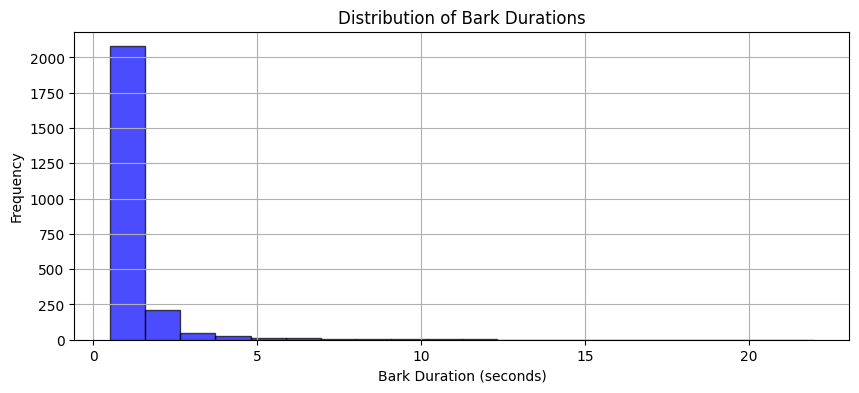

In [31]:
# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(bark_durations, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Bark Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Bark Durations")
plt.grid(True)
plt.show()

We can see that there are a very small amount of barks that are larger than 4 seconds. Let's remove these files.

In [32]:
target_duration = 4 # in seconds
target_length = target_duration * sample_rate

for file in os.listdir("segmented_barks"):
  file_path = os.path.join("segmented_barks", file)

  # Load the audio file
  y, sr = librosa.load(file_path, sr=None)
  duration = len(y) / sr  # Convert samples to seconds

  # Remove file if it exceeds max_duration
  if duration > target_duration:
    os.remove(file_path)
    # Uncomment to show which files are removed
    # print(f"Removed: {file} (Duration: {duration:.2f}s)")
  # Otherwise, pad the file to be 4 seconds
  elif duration < target_duration:
    padded_y = np.pad(y, (0, target_length - len(y)), mode='constant')
    sf.write(file_path, padded_y, sample_rate)
    # Uncomment to show which files are padded
    # print(f"Padded: {file} to 4 seconds")

Add segmented_barks to the old dataframe.

In [33]:
# Create a new DataFrame for segmented barks
bark_data = []

# Iterate over segmented bark files
for file in os.listdir("segmented_barks"):
  # Extract the file index from the filename (assuming format "bark_<file-num>_<seg-num>.wav")
  file_index = int(file.split("_")[1])

  # Find the original row using the file index
  # Recall the old dataframe is called anno
  row = anno.iloc[file_index].to_dict()

  # Update the "single_bark" column with the segmented file path
  row["single_bark"] = os.path.join("segmented_barks", file)

  # Append updated row to the new dataset
  bark_data.append(row)

# Create a new DataFrame with the segmented barks
df_barks = pd.DataFrame(bark_data)
df_barks = df_barks.drop(columns=["audio"])

df_barks.head()

,filename,name,context,age,weight,sex,breed,single_bark
0,Mac-2-P-2f.aif,Mac,play,5,34,male,German shorthair pointer,segmented_barks/bark_79_1.wav
1,Roodie-8-P-8b.aif,Roodie,play,12,18,male,Australian cattle dog,segmented_barks/bark_285_3.wav
2,Mac-4-A-4.aif,Mac,aggression,5,34,male,German shorthair pointer,segmented_barks/bark_110_14.wav
3,Mac-11-C-9a.aif,Mac,contact,5,34,male,German shorthair pointer,segmented_barks/bark_120_0.wav
4,Zoe-1-A-1.aif,Zoe,aggression,7,16,female,Australian cattle dog,segmented_barks/bark_225_0.wav


Data preprocessing is complete. The files that will be useful in training a model are `segmented_barks`, which is a folder containing all single bark audio files, and `updated_dataset.csv`, which is a csv with each segmented bark with its corresonding labels.

In [34]:
# Save the updated dataset
df_barks.to_csv("updated_dataset.csv", index=False)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
import os
from scipy import signal

class BarkDataset(Dataset):
    def __init__(self, csv_path, audio_folder, transform=None):
        self.data = pd.read_csv(csv_path)
        self.audio_folder = audio_folder
        self.transform = transform
        self.label_map = {"Farley": 0, "Freid": 1, "Keri": 2, "Louie": 3, "Luke": 4, "Mac": 5, "Roodie": 6, "Rudy": 7, "Siggy": 8, "Zoe": 9}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        audio_path = os.path.join(self.audio_folder, os.path.basename(row["single_bark"]))
        y, sr = librosa.load(audio_path, sr=None)

        # Compute spectrogram
        freqs, times, Sx = signal.spectrogram(y, fs=sr)
        Sx = Sx[:59]
        Sx = 10 * np.log10(Sx + 1e-10)

        # Resize to fixed size (59, 344) for CNN input
        Sx_resized = np.zeros((59, 344))
        width = min(Sx.shape[1], 344)
        Sx_resized[:, :width] = Sx[:, :width]

        spec_tensor = torch.tensor(Sx_resized, dtype=torch.float32).unsqueeze(0)
        label = self.label_map[row["name"]]
        return spec_tensor, label

full_dataset = BarkDataset(csv_path="updated_dataset.csv", audio_folder="segmented_barks")

train_size = int(0.33 * len(full_dataset))
val_size = int(0.33 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Modified version by Deborah, you'll find the orginial model after this section.

In [40]:
#orginal CNN
'''
class CNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=3):  # context has 3 classes
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=5, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding="same")

        # For spectrogram shape: (1, 59, 344) → after 3x maxpool2d(2), dims = (20, 7, 43)
        self.flattened_size = 20 * 7 * 43
        self.linear = nn.Linear(self.flattened_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, start_dim=1)
        x = F.softmax(x, dim=1)
        x = self.linear(x)
        return x
'''

class CNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=3):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding="same")
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same")
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.bn4 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=0.5)

        # Dynamically calculate flattened size
        self.flattened_size = self.get_flattened_size((1, 1, 59, 344))
        self.linear = nn.Linear(self.flattened_size, num_classes)

    def get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(input_shape)
            x = self.conv1(x)
            x = self.bn1(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)

            x = self.conv2(x)
            x = self.bn2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)

            x = self.conv3(x)
            x = self.bn3(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)

            x = self.conv4(x)
            x = self.bn4(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)

            return x.numel()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return F.softmax(x, dim=1)



In [41]:
def accuracy(y_hat, y):
    preds = torch.argmax(y_hat, dim=1)
    return (preds == y).float().mean()

In [44]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
lr_values = [0.001, 0.0001, 0.00005, 0.00001]
num_epochs = 20  # Increased epochs for deeper models
early_stopping_patience = 5
scheduler_step_size = 5
scheduler_gamma = 0.1

cnn_metrics = {}
cnn_models = {}
loss_fn = nn.CrossEntropyLoss()

for lr in lr_values:
    cnn_metrics[lr] = {"accuracies": [], "losses": []}

    # Initialize the CNN with dynamic flattened size computation
    cnn = CNN(input_channels=1, num_classes=10).to(DEVICE)
    optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    cnn_models[lr] = cnn

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        cnn.train()  # Set model to training mode
        train_loss_sum = 0

        for iteration, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(DEVICE)
            y_train = y_train.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass through the updated CNN
            y_hat = cnn(X_train)
            train_loss = loss_fn(y_hat, y_train)
            train_loss.backward()
            optimizer.step()

            train_loss_sum += train_loss.item()

        scheduler.step()  # Adjust learning rate

        cnn.eval()  # Set model to evaluation mode
        with torch.no_grad():
            val_accuracy_sum = 0
            val_loss_sum = 0

            for X_val, y_val in val_loader:
                X_val = X_val.to(DEVICE)
                y_val = y_val.to(DEVICE)

                # Forward pass during validation
                y_hat = cnn(X_val)

                val_accuracy_sum += (torch.argmax(y_hat, dim=1) == y_val).float().mean()
                val_loss_sum += loss_fn(y_hat, y_val)

            val_loss = (val_loss_sum / len(val_loader)).cpu()
            val_accuracy = (val_accuracy_sum / len(val_loader)).cpu()

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered for learning rate {lr}.")
                    break

            # Update metrics
            cnn_metrics[lr]["accuracies"].append(val_accuracy.item())
            cnn_metrics[lr]["losses"].append(val_loss.item())

        # Logging information
        print(f"LR = {lr} --- EPOCH = {epoch + 1}")
        print(f"Training loss = {train_loss_sum / len(train_loader):.4f}")
        print(f"Validation loss = {val_loss:.4f} --- Validation accuracy = {val_accuracy:.4f}")


LR = 0.001 --- EPOCH = 1
Training loss = 2.3020
Validation loss = 2.3098 --- Validation accuracy = 0.1514
LR = 0.001 --- EPOCH = 2
Training loss = 2.2935
Validation loss = 2.3098 --- Validation accuracy = 0.1514
LR = 0.001 --- EPOCH = 3
Training loss = 2.2999
Validation loss = 2.3098 --- Validation accuracy = 0.1514
LR = 0.001 --- EPOCH = 4
Training loss = 2.2999
Validation loss = 2.3098 --- Validation accuracy = 0.1514
LR = 0.001 --- EPOCH = 5
Training loss = 2.2999
Validation loss = 2.3098 --- Validation accuracy = 0.1514
Early stopping triggered for learning rate 0.001.
LR = 0.0001 --- EPOCH = 1
Training loss = 2.2713
Validation loss = 2.2542 --- Validation accuracy = 0.1821
LR = 0.0001 --- EPOCH = 2
Training loss = 2.2158
Validation loss = 2.2056 --- Validation accuracy = 0.2758
LR = 0.0001 --- EPOCH = 3
Training loss = 2.1827
Validation loss = 2.1733 --- Validation accuracy = 0.3158
LR = 0.0001 --- EPOCH = 4
Training loss = 2.1421
Validation loss = 2.1678 --- Validation accuracy =

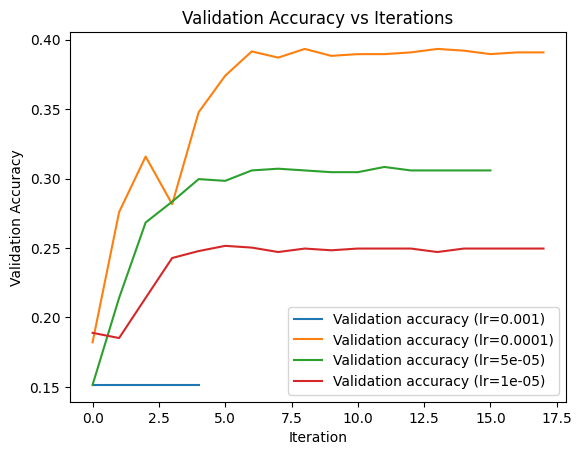

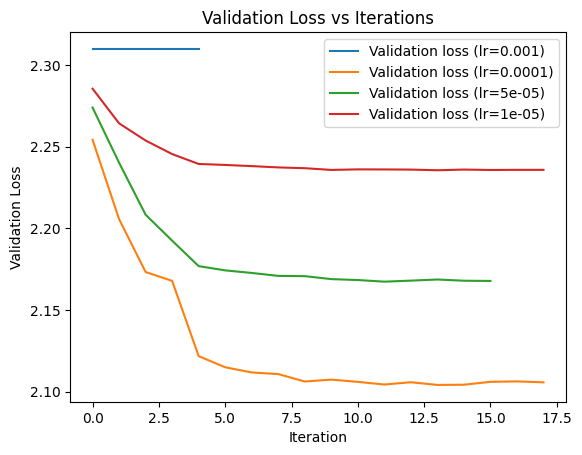

Test set accuracy of best CNN model (lr=0.0001): 0.3894
Number of parameters in CNN: 178282


In [45]:
#Changing plotting for new training
# Validation Accuracy Plot
for lr in lr_values:
    x_axis = list(range(len(cnn_metrics[lr]["accuracies"])))  # Dynamically calculate x-axis length
    plt.plot(x_axis, cnn_metrics[lr]["accuracies"], label=f"Validation accuracy (lr={lr})")

plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Iterations")
plt.legend()
plt.show()

# Validation Loss Plot
for lr in lr_values:
    x_axis = list(range(len(cnn_metrics[lr]["losses"])))  # Dynamically calculate x-axis length
    plt.plot(x_axis, cnn_metrics[lr]["losses"], label=f"Validation loss (lr={lr})")

plt.xlabel("Iteration")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Iterations")
plt.legend()
plt.show()


best_lr = min(lr_values, key=lambda lr: min(cnn_metrics[lr]["losses"]))  # Find best learning rate
best_cnn = cnn_models[best_lr]  # Get the best CNN model

# Evaluate on the test set
test_accuracy_sum = 0
for X_test, y_test in test_loader:
    X_test = X_test.to(DEVICE)
    y_test = y_test.to(DEVICE)
    y_hat = best_cnn(X_test)
    test_accuracy_sum += accuracy(y_hat, y_test)

test_accuracy = (test_accuracy_sum / len(test_loader)).cpu()
print(f"Test set accuracy of best CNN model (lr={best_lr}): {test_accuracy:.4f}")

# Display model complexity
total_params_cnn = sum(param.numel() for param in best_cnn.parameters())
print(f"Number of parameters in CNN: {total_params_cnn}")


# The following is the original model

In [ ]:
#original CNN
class CNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=3):  # context has 3 classes
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=5, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding="same")

        # For spectrogram shape: (1, 59, 344) → after 3x maxpool2d(2), dims = (20, 7, 43)
        self.flattened_size = 20 * 7 * 43
        self.linear = nn.Linear(self.flattened_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, start_dim=1)
        x = F.softmax(x, dim=1)
        x = self.linear(x)
        return x

In [ ]:
#orginal training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
lr_values = [0.01, 0.001, 0.0001]
num_epochs = 10
num_iterations_before_validation = 1000

cnn_metrics = {}
cnn_models = {}

loss_fn = nn.CrossEntropyLoss()

for lr in lr_values:
    cnn_metrics[lr] = {
        "accuracies": [],
        "losses": []
    }

    cnn = CNN().to(DEVICE)
    optimizer = optim.Adam(cnn.parameters(), lr)
    cnn_models[lr] = cnn

    for epoch in range(num_epochs):
        for iteration, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(DEVICE)
            y_train = y_train.to(DEVICE)
            optimizer.zero_grad()
            y_hat = cnn(X_train)
            train_loss = loss_fn(y_hat, y_train)
            train_loss.backward()
            optimizer.step()

            if iteration == len(train_loader) - 1:

                with torch.no_grad():
                    val_accuracy_sum = 0
                    val_loss_sum = 0
                    for X_val, y_val in val_loader:
                        X_val = X_val.to(DEVICE)
                        y_val = y_val.to(DEVICE)
                        y_hat = cnn(X_val)
                        val_accuracy_sum += accuracy(y_hat, y_val)
                        val_loss_sum += loss_fn(y_hat, y_val)
                    val_accuracy = (val_accuracy_sum / len(val_loader)).cpu()
                    val_loss = (val_loss_sum / len(val_loader)).cpu()
                    cnn_metrics[lr]["accuracies"].append(val_accuracy)
                    cnn_metrics[lr]["losses"].append(val_loss)
                    print(f"LR = {lr} --- EPOCH = {epoch} --- ITERATION = {iteration}")
                    print(f"Validation loss = {val_loss:.4f} --- Validation accuracy = {val_accuracy:.4f}")



LR = 0.01 --- EPOCH = 0 --- ITERATION = 24
Validation loss = 1.0962 --- Validation accuracy = 0.3515
LR = 0.01 --- EPOCH = 1 --- ITERATION = 24
Validation loss = 1.0964 --- Validation accuracy = 0.3553
LR = 0.01 --- EPOCH = 2 --- ITERATION = 24
Validation loss = 1.0927 --- Validation accuracy = 0.3653
LR = 0.01 --- EPOCH = 3 --- ITERATION = 24
Validation loss = 1.0925 --- Validation accuracy = 0.3665
LR = 0.01 --- EPOCH = 4 --- ITERATION = 24
Validation loss = 1.0968 --- Validation accuracy = 0.3590
LR = 0.01 --- EPOCH = 5 --- ITERATION = 24
Validation loss = 1.0974 --- Validation accuracy = 0.3628
LR = 0.01 --- EPOCH = 6 --- ITERATION = 24
Validation loss = 1.0999 --- Validation accuracy = 0.3628
LR = 0.01 --- EPOCH = 7 --- ITERATION = 24
Validation loss = 1.0999 --- Validation accuracy = 0.3628
LR = 0.01 --- EPOCH = 8 --- ITERATION = 24
Validation loss = 1.1024 --- Validation accuracy = 0.3615
LR = 0.01 --- EPOCH = 9 --- ITERATION = 24
Validation loss = 1.1049 --- Validation accuracy

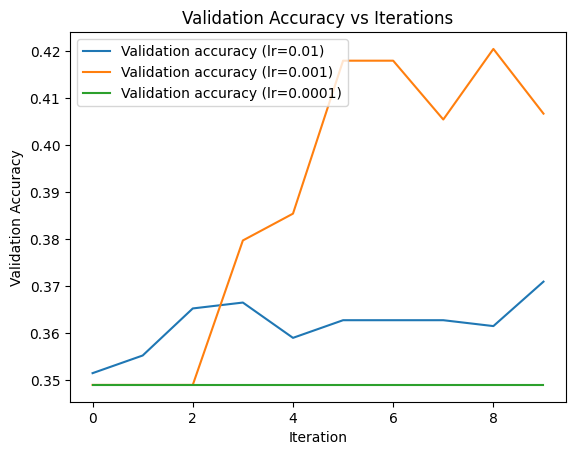

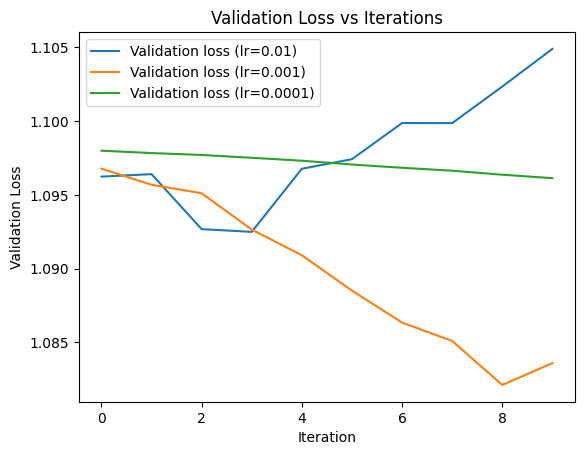

Test set accuracy of best CNN model: 0.4243
Number of parameters in CNN: 20393


In [ ]:
#original plotting plus lr 0.0001
x_axis = list(range(len(cnn_metrics[0.01]["accuracies"])))

plt.plot(x_axis, cnn_metrics[0.01]["accuracies"], label="Validation accuracy (lr=0.01)")
plt.plot(x_axis, cnn_metrics[0.001]["accuracies"], label="Validation accuracy (lr=0.001)")
plt.plot(x_axis, cnn_metrics[0.0001]["accuracies"], label="Validation accuracy (lr=0.0001)")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Iterations")
plt.legend()
plt.show()

plt.plot(x_axis, cnn_metrics[0.01]["losses"], label="Validation loss (lr=0.01)")
plt.plot(x_axis, cnn_metrics[0.001]["losses"], label="Validation loss (lr=0.001)")
plt.plot(x_axis, cnn_metrics[0.0001]["losses"], label="Validation loss (lr=0.0001)")
plt.xlabel("Iteration")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Iterations")
plt.legend()
plt.show()

test_accuracy_sum = 0
best_cnn = cnn_models[0.001]

for X_test, y_test in test_loader:
    X_test = X_test.to(DEVICE)
    y_test = y_test.to(DEVICE)
    y_hat = best_cnn(X_test)
    test_accuracy_sum += accuracy(y_hat, y_test)

test_accuracy = (test_accuracy_sum / len(test_loader)).cpu()
print(f"Test set accuracy of best CNN model: {test_accuracy:.4f}")

total_params_cnn = sum(param.numel() for param in best_cnn.parameters())
print(f"Number of parameters in CNN: {total_params_cnn}")

# Confusion Matrix

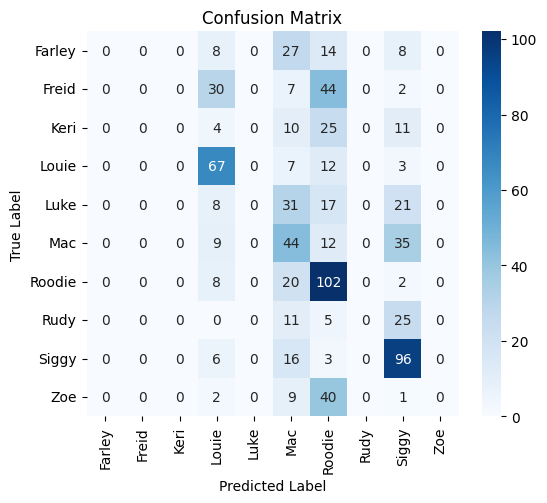

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_and_plot_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

class_names = ["Farley", "Freid", "Keri", "Louie", "Luke", "Mac", "Roodie", "Rudy", "Siggy", "Zoe"]

best_lr = min(cnn_metrics, key=lambda lr: min(cnn_metrics[lr]["losses"]))  # Find best LR
best_model = cnn_models[best_lr]  # Get corresponding model

# Run confusion matrix evaluation
evaluate_and_plot_confusion_matrix(best_model, test_loader, DEVICE, class_names)
